# 'Ohi'a Lehua Population Model with a Spatial Gaussian Process Classifier

Airborn imaging spectroscopy is a valuable method to characterize the distribution of plant life for ecological, agricultural, and environmental research. In this study, spectroscopy measurements of 'Ohi'a Lehua, a keystone tree species on the Big Island of Haw'aii, were collected for tree samples at various locations across the island. This data was used to train support vector machine (SVM) and spectral unmixing (SU) machine learning models to identify the tree species based on the measured spectra. Then, airborn imaging spectroscopy was used to record spectroscopic measurements spanning the whole island. The SVM and SU models were implemented to predict the spatial distribution of 'Ohi'a Lehua based on the airborn imaging spectroscopy data. 

Based on raw score accuracy, both the SVM and SU models performed well (> 90%). However, it was noted that the SU model tended to predict 'Ohi'a Lehua trees in grassland type areas where it is known that 'Ohi'a Lehua does not live, whereas the SVM model appeared to have a more reasonable spatial distribution.     

In this notebook, a Gaussian process classifier (GPC) is used to classify the probability of observing 'Ohi'a Lehua independently of the spectral measurements. The GPC model was then compared to the predictions from the SVM and SU models. It is found that the SVM model agrees closely with the GPC model, as expected by our intuition and knowledge of the Big Island, whereas the SU model differs substantially. In this way, the GPC model serves as an important validation step to estimate the spatial accuracy of machine learning models for airborn imaging spectroscopy data. 

In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from   pickle import dump, load

# scikit learn for gaussian process classification with standard RBF kernel
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# just to make plots look nice
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':12})
rc('mathtext',**{'default':'regular'})
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")

In [2]:
# import and manipulate data into useful forms
x       = np.load('x_all.npy')           # x-coordinate
y       = np.load('y_all.npy')           # y-coordinate
# spectra = np.load('data_all.npy')        # spectra for SVM model
key     = np.load('key_all.npy')         # true observations
svm     = np.load('model_class_all.npy') # svm predicted at x,y
mesma   = np.load('mesma_all.npy')       # spectral unmixing predicted at x,y

x = x.astype('float')    
y = y.astype('float')
data = pd.DataFrame({'x':x, 'y':y, 'key':key,'svm':svm})

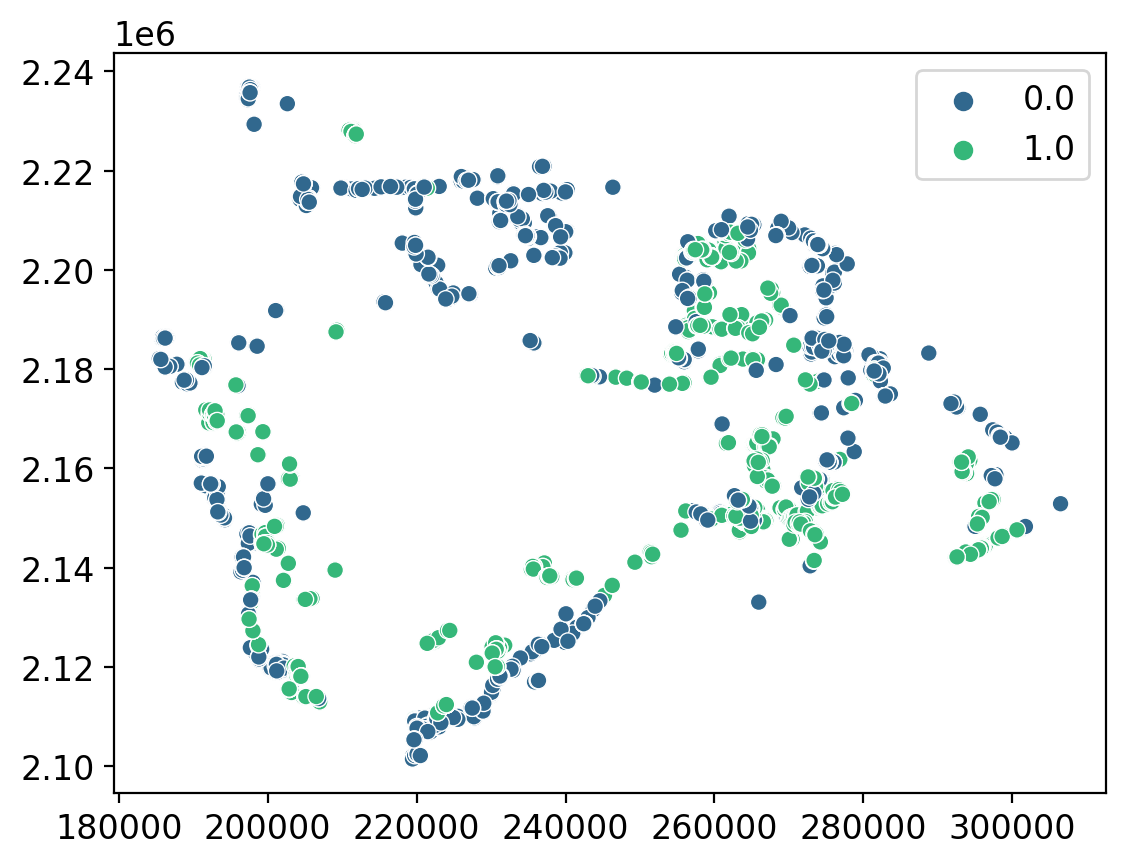

In [3]:
# visualize experimental data
sns.scatterplot(data = data, x = x, y = y, hue = key, palette = 'viridis')
plt.show()

## Gaussian Process Classification for Spatial Ohia Population Distribution

A Gaussian Process is a kernel-based, non-parametric machine learning model used for regression and classification that is mathematically equivalent to a single layer neural network with infinite nodes. A Gaussian process acts as a probabilistic function approximator that takes in model outputs and provides an estimate for the distribution of functions that fi a set of training data. 

The kernel, or covariance function, describes how the function varies as the input parameters change. For instance, in physical modeling we are usually dealing with differentiable and continuous functions, and the proper choice of covariance function can encapsulate this information. The kernel function usually contains a set of parameters known as hyperparameters which need to be optimized for the given training data.  

Here we implement the GaussianProcessClassifier function from scikit-learn with a radial basis function. Details of the scikit-learn function can be found at this link: https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html

In [4]:
num = 100                                # defines the number of test points across the map in x- and y-direction
x_grid = np.linspace(min(x),max(x),num)
y_grid = np.linspace(min(y),max(y),num)

try:
    input_dict = load(open('spatialgpc.p', 'rb'))
    out = input_dict['spatialgpc']
    acc = input_dict['accuracy']
    
except:
    # preliminaries
    def unison_shuffled_copies(a, b):     # function to shuffle samples in unison
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    X = np.zeros((len(x), 2))             # just putting the variables into an easy to use form
    X[:,0] = x
    X[:,1] = y
    X,key = unison_shuffled_copies(X,key) # use the shuffled copies so training samples are randomized
    N = int(len(x)*0.7)                   # 70% of data used for training 

    # train gaussian process classifier on spatial coordinates
    kernel = 1.0 * RBF(1.0)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X[:N], key[:N])
    acc = gpc.score(X[N:], key[N:])

    # evaluate the gaussian process classifier over a spatial map of the island (takes ~20 minutes)
    num = 100                               # defines the number of test points across the map in x- and y-direction
    x_grid = np.linspace(min(x),max(x),num)
    y_grid = np.linspace(min(y),max(y),num)
    out = np.zeros((num,num))               # define variable for spatial map
    j = 0
    for xval in x_grid:
        i = 0
        for yval in y_grid:
            testInput = np.array([[xval,yval]])
            out[i,j]  = np.abs(1-gpc.predict_proba(testInput)[0,0])
            i += 1
        j += 1
    #save data    
    output_dict = dict(spatialgpc = out, accuracy = acc)
    dump(output_dict, open('spatialgpc.p', 'wb'))

Now that we have generated the 'Ohi'a Lehua spatial probability distribution, we can compare it to the predictions from the SVM and SU models.  

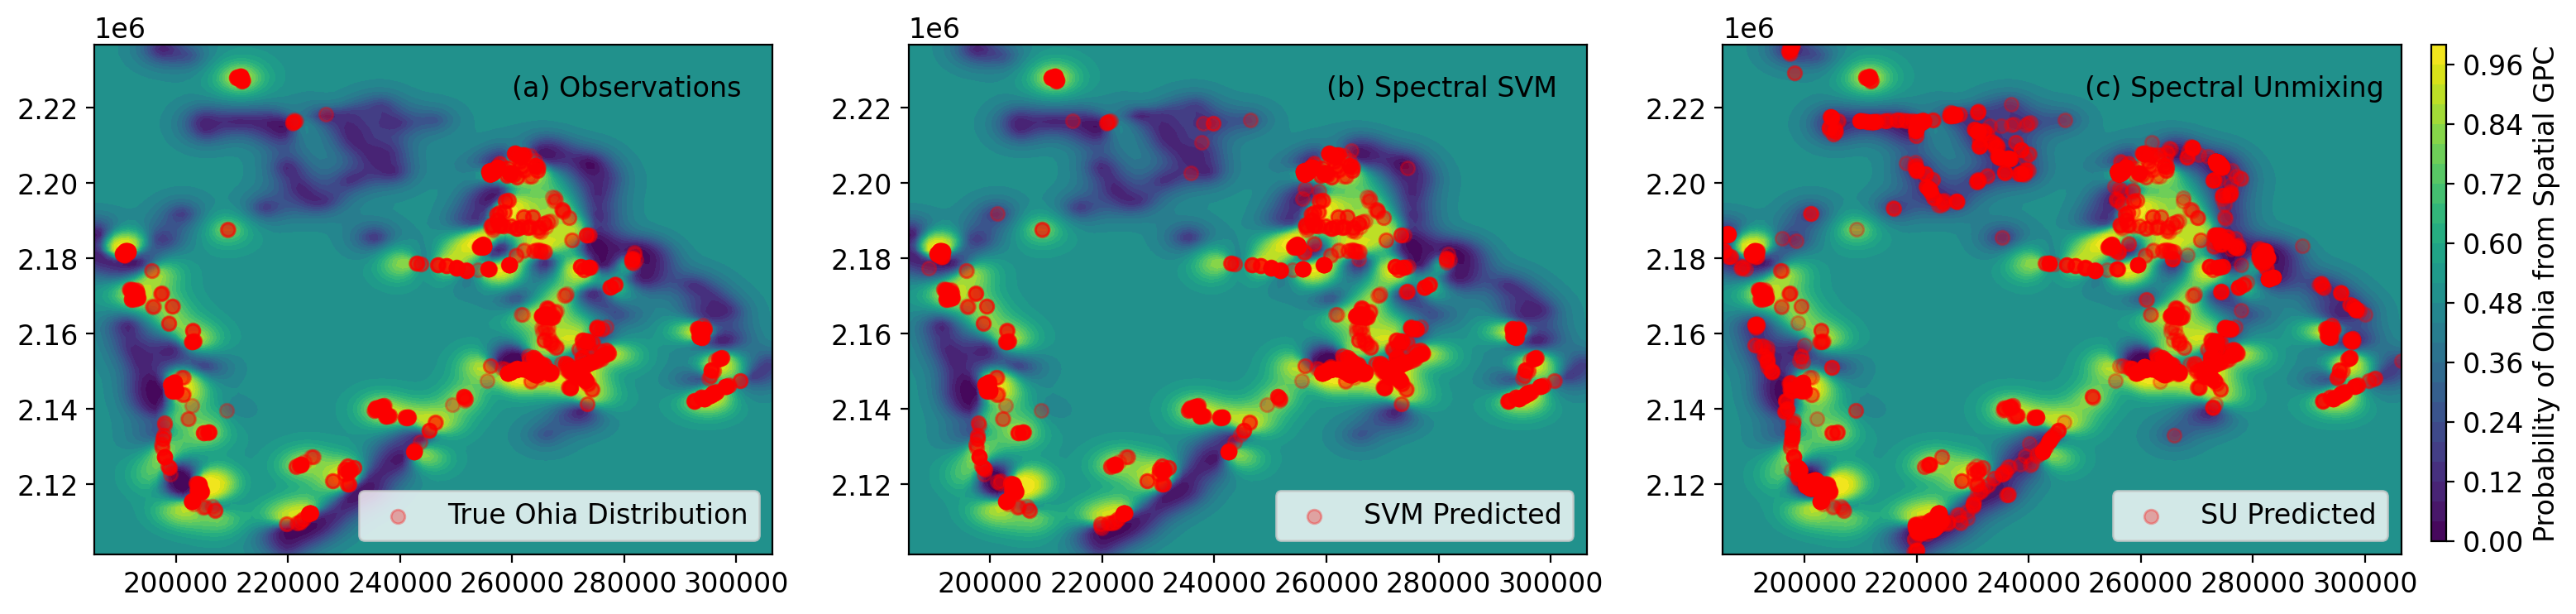

In [5]:
# visualize spatial GPC results vs spectroscopic SVM and spectral unmixing results
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
axs[0].contourf(x_grid, y_grid, out, levels = 25, cmap = 'viridis')
axs[0].scatter(x[np.where(key == 1)], y[np.where(key == 1)], color='r', alpha = 0.3, label = 'True Ohia Distribution')
axs[0].text(260000, 2.223e6, '(a) Observations', fontsize = 12)
axs[0].legend(loc = 'lower right')
axs[1].contourf(x_grid, y_grid, out, levels = 25, cmap = 'viridis')
axs[1].scatter(x[np.where(svm == 1)], y[np.where(svm == 1)], color='r', alpha = 0.3, label = 'SVM Predicted')
axs[1].text(260000, 2.223e6, '(b) Spectral SVM', fontsize = 12)
axs[1].legend(loc = 'lower right')
CS = axs[2].contourf(x_grid, y_grid, out, levels = 25, cmap = 'viridis')
axs[2].scatter(x[np.where(mesma == 0)], y[np.where(mesma == 0)], color='r', alpha = 0.3, label = 'SU Predicted')
axs[2].text(250000, 2.223e6, '(c) Spectral Unmixing', fontsize = 12)
axs[2].legend(loc = 'lower right')
cbar_ax = fig.add_axes([0.91, 0.13, 0.005, 0.75])
cbar = fig.colorbar(CS, cax=cbar_ax)
cbar.ax.set_ylabel('Probability of Ohia from Spatial GPC')
plt.show()

(a) Spatial distribution calculated with GPC compared to the known samples of 'Ohi'a Lehua. Note that the high probability areas correspond with yellow regions (high probability) whereas no samples are observed in low probability regions (dark blue region). (b) Comparison of the SVM predicted distribution vs the GPC distribution shows that most SVM predicted samples are found in high probability regions. (c) Comparison of the SU predicted distribution vs GPC distribution shows that SU often predicts 'Ohi'a Lehua in low probability regions.

Based on these distributions, the SVM model is more likely to reasonably model the true distribution of 'Ohi'a Lehua.

[1] Seeley, M.M.; Vaughn, N.R.; Shanks, B.L.; Martin, R.E.; König, M.; Asner, G.P. Classifying a Highly Polymorphic Tree Species across Landscapes Using Airborne Imaging Spectroscopy. Preprints 2023, 2023071570. https://doi.org/10.20944/preprints202307.1570.v1